In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    !git clone -qq https://github.com/Intelligent-Systems-Phystech/ProjectTemplate.git /tmp/repo
    !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo

In [2]:
import sys
sys.path.append('../src')

from mylib.data_loader import load_data
from mylib.logistic_regression import create_worker_func, f, loss
from mylib.compression_ops import identity_op, top_k_op, svd_approximation_low_rank_compression_op, hosvd_approximation_low_rank_compression_op
from mylib.distributed_gd import DistributedGD, Worker

import numpy as np
import matplotlib.pyplot as plt

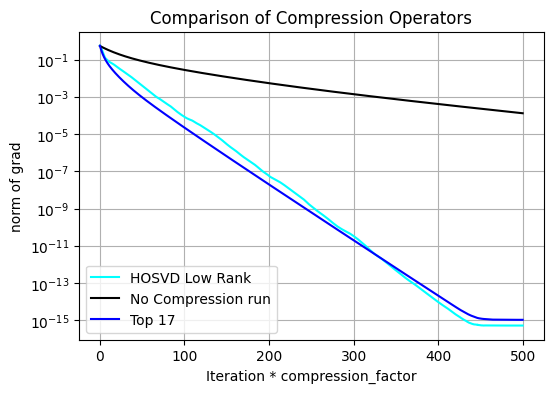

In [3]:
X_train, X_test, y_train, y_test = load_data("../src/dataset/mushrooms.txt")

L = np.max(np.linalg.eigvals(X_train.T @ X_train)).real / X_train.shape[0]
lambda_value = L / 100

workers = [Worker(create_worker_func(f, X_train, y_train, lambda_value))]
dgd = DistributedGD(workers, 1 / L)

crit = [
    lambda w: np.linalg.norm(f.grad(w, X_train, y_train, lambda_value)),  
    lambda w: np.mean(np.sign(X_train @ w) == y_train),
    lambda w: loss(w, X_train, y_train, 0)
]

def plot_for_compression_operator(w0, num_iter, compress_op, compression_factor, name, color):
    for worker in workers:
        worker.compress_op = compress_op

    dgd.reset()
    dgd.run_ef21(int(num_iter/compression_factor)+1, w0)
    run_ef21_crit_history = [crit[0](g) for g in dgd.history]

    scaled_iterations = [i * compression_factor for i in range(len(run_ef21_crit_history))]

    plt.semilogy(scaled_iterations, run_ef21_crit_history, label=f'{name}', color=color)


plt.figure(figsize=(6, 4))

compression_operators = [
    (hosvd_approximation_low_rank_compression_op(1), 17/112, 'HOSVD Low Rank', 'cyan'),
    (identity_op(), 1, 'No Compression run', 'black'),
    (top_k_op(17), 17/112, 'Top 17', 'blue'),
    # (svd_approximation_low_rank_compression_op(1), (14+8)/112, 'SVD Low Rank = 1', 'green')
]

np.random.seed(0)
w0 = np.zeros(112) 
num_iter = 500

for compress_op, compression_factor, name, color in compression_operators:
    plot_for_compression_operator(w0, num_iter, compress_op, compression_factor, name, color)

plt.xlabel('Iteration * compression_factor')
plt.ylabel('norm of grad')
plt.title('Comparison of Compression Operators')
plt.grid(True)
plt.legend()
plt.show()
